In [ ]:
import sys
sys.path.insert(0, "/Users/abali/Documents/github projects/semantic-video-retrieval")
from clip_embedding import embed_frame,embed_text
import os
import numpy as np
import faiss
import pickle



In [ ]:


from extract_chunks_updated import extract_chunks
# ✅ Set paths
video_folder = "/Users/abali/Documents/github projects/semantic-video-retrieval/data/videos"
frames_output_folder = "/Users/abali/Documents/github projects/semantic-video-retrieval/data/chunks"
# index_path = "/Users/abali/github projects/semantic-video-retrieval/embeddings/faiss_index"
# metadata_path = "/Users/abali/github projects/semantic-video-retrieval/embeddings/metadata"

# ✅ Extract chunks from videos
all_metadata = []
for fname in os.listdir(video_folder):
    if fname.endswith(".mp4"):
        video_path = os.path.join(video_folder, fname)
        print(f"📦 Processing {fname}...")
        chunks = extract_chunks(video_path, frames_output_folder, chunk_duration=15, fps=1)
        all_metadata.extend(chunks)



In [ ]:


def get_chunk_embeddings(chunk_folder_root):
    """
    Given a directory of chunks (each containing frames), compute the average embedding
    for each chunk and return a list of {chunk_id, embedding}.
    """
    chunk_embeddings = []

    for chunk_name in sorted(os.listdir(chunk_folder_root)):
        chunk_path = os.path.join(chunk_folder_root, chunk_name)
        if not os.path.isdir(chunk_path):
            continue

        print(f"🔍 Processing {chunk_name}...")
        frame_embeddings = []

        for fname in sorted(os.listdir(chunk_path)):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                image_path = os.path.join(chunk_path, fname)
                emb = embed_frame(image_path)
                if emb is not None and not np.isnan(emb).any():
                    frame_embeddings.append(emb)
        
        if frame_embeddings:
            mean_emb = np.mean(frame_embeddings, axis=0).astype("float32")
            chunk_embeddings.append({
                "chunk_id": chunk_name,
                "embedding": mean_emb
            })
            print(f"✅ Embedded: {chunk_name} ({len(frame_embeddings)} frames)")
        else:
            print(f"⚠️ No valid frames found for {chunk_name}")

    return chunk_embeddings


In [ ]:
chunk_embeddings=get_chunk_embeddings('/Users/abali/Documents/github projects/semantic-video-retrieval/data/chunks')

In [ ]:
import os
import pickle
import numpy as np
import faiss

def store_embeddings_to_faiss(embedding_data, index_path, metadata_path):
    if not embedding_data:
        print("⚠️ No embeddings to store.")
        return

    os.makedirs(os.path.dirname(index_path), exist_ok=True)
    os.makedirs(os.path.dirname(metadata_path), exist_ok=True)

    embeddings = [item["embedding"] for item in embedding_data]
    metadata = [{"chunk_id": item["chunk_id"]} for item in embedding_data]

    arr = np.vstack(embeddings).astype("float32")
    print(f"📐 FAISS index shape: {arr.shape}")

    index = faiss.IndexFlatL2(arr.shape[1])
    index.add(arr)

    faiss.write_index(index, index_path)
    with open(metadata_path, "wb") as f:
        pickle.dump(metadata, f)

    print(f"✅ Stored {len(arr)} vectors in FAISS and metadata")


In [ ]:
store_embeddings_to_faiss(chunk_embeddings, '/Users/abali/Documents/github projects/semantic-video-retrieval/embeddings/faiss_index/video_chunks.index', '/Users/abali/Documents/github projects/semantic-video-retrieval/embeddings/metadata/chunk_metadata.pkl')  

In [ ]:
def search_top_chunks(query, index_path, metadata_path, k=5):
    # Load index
    index = faiss.read_index(index_path)

    # Load metadata
    with open(metadata_path, "rb") as f:
        metadata = pickle.load(f)

    # Embed query
    query_embedding = embed_text(query).astype("float32").reshape(1, -1)

    # Search
    D, I = index.search(query_embedding, k)

    # Collect results
    results = []
    for i in I[0]:
        if i < len(metadata):
            results.append(metadata[i])
    
    return results

In [ ]:
results = search_top_chunks(
    query="moving cars",
    index_path="/Users/abali/github projects/semantic-video-retrieval/embeddings/faiss_index/video_chunks.index",
    metadata_path="/Users/abali/github projects/semantic-video-retrieval/embeddings/metadata/chunk_metadata.pkl",k=1)

for r in results:
    print(f"🎬 Chunk: {r['chunk_id']}")


In [ ]:
import os
import subprocess

# Loop through the search results and play the video
for r in results:
    # Extract the base video file name (e.g., sample1.mp4 from sample1_chunk0)
    video_name = r['chunk_id'].split('_')[0] + '.mp4'
    
    # Construct the full video path
    video_path = os.path.join("/Users/abali/Documents/github projects/semantic-video-retrieval/data/videos", video_name)

    print(f"🎬 Chunk: {r['chunk_id']}")

    # Ensure the video exists
    if os.path.exists(video_path):
        print(f"▶️ Opening video {video_name}...")

        # Use ffplay to open the entire video
        subprocess.Popen(["open", video_path])  # macOS-specific command to open video with default player
    else:
        print(f"⚠️ Video not found: {video_path}")


In [ ]:
import pickle

with open("/Users/abali/Documents/github projects/semantic-video-retrieval/embeddings/metadata/chunk_metadata.pkl", "rb") as f:
    metadata = pickle.load(f)

print(metadata[7])


In [ ]:
metadata

In [ ]:
# Sample enhancement (you can adapt this based on your real folder structure)
from pathlib import Path

updated_metadata = []
for entry in metadata:
    chunk_id = entry['chunk_id']
    video_id = chunk_id.split('_')[0]
    chunk_folder = Path(f"/Users/abali/Documents/github projects/semantic-video-retrieval/data/chunks/{chunk_id}")
    frame_files = sorted(chunk_folder.glob("frame_*.jpg"))

    enriched = {
        "chunk_id": chunk_id,
        "video_id": video_id,
        "frame_paths": [str(p) for p in frame_files],
        "num_frames": len(frame_files),
        "start_frame": int(frame_files[0].stem.split('_')[-1]) if frame_files else None,
        "end_frame": int(frame_files[-1].stem.split('_')[-1]) if frame_files else None,
    }
    updated_metadata.append(enriched)

# Save this enriched metadata for graph construction
import pickle
with open("/Users/abali/Documents/github projects/semantic-video-retrieval/embeddings/metadata/chunk_metadata.pkl", "wb") as f:
    pickle.dump(updated_metadata, f)


In [ ]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

local_path = "/Users/abali/Documents/github projects/semantic-video-retrieval/local_models/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(local_path)
processor = ViTImageProcessor.from_pretrained(local_path)
tokenizer = AutoTokenizer.from_pretrained(local_path)


## Adding Image Description to Enrich Metadata

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch

local_path = "/Users/abali/Documents/github projects/semantic-video-retrieval/local_models/blip-image-captioning-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained(local_path)
model = BlipForConditionalGeneration.from_pretrained(local_path).to(device)


## Adding Description,Entities/ Objects to metadata

In [ ]:
import os
import pickle
import torch
from PIL import Image
from transformers import (
    VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer,
    BlipProcessor, BlipForConditionalGeneration
)
import spacy
from ultralytics import YOLO

# === CONFIG ===
USE_BLIP = True  # 🔁 Toggle this to False to use ViT-GPT2
device = "cuda" if torch.cuda.is_available() else "cpu"

# === Load Captioning Model ===
if USE_BLIP:
    blip_path = "/Users/abali/Documents/github projects/semantic-video-retrieval/local_models/blip-image-captioning-base"
    processor = BlipProcessor.from_pretrained(blip_path)
    caption_model = BlipForConditionalGeneration.from_pretrained(blip_path).to(device)
    tokenizer = processor.tokenizer  # BLIP uses same tokenizer object
else:
    vit_path = "/Users/abali/Documents/github projects/semantic-video-retrieval/local_models/vit-gpt2-image-captioning"
    caption_model = VisionEncoderDecoderModel.from_pretrained(vit_path).to(device)
    processor = ViTImageProcessor.from_pretrained(vit_path)
    tokenizer = AutoTokenizer.from_pretrained(vit_path)

# === Load NLP and Object Detection Models ===
nlp = spacy.load("en_core_web_sm")
yolo_model = YOLO("yolov8n.pt")  # Swap with yolov8m.pt if needed

# === Frame Processors ===
def generate_caption(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

        with torch.no_grad():
            output_ids = caption_model.generate(pixel_values, max_length=20, num_beams=4)

        caption = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
        return caption
    except Exception as e:
        print(f"❌ Caption error on {image_path}: {e}")
        return None

def extract_entities(texts):
    entities = set()
    for txt in texts:
        doc = nlp(txt)
        entities.update([ent.text.lower() for ent in doc.ents])
        entities.update([chunk.text.lower() for chunk in doc.noun_chunks])
    return list(entities)

def detect_objects(image_path):
    try:
        results = yolo_model(image_path)
        objects = set()
        for r in results:
            for box in r.boxes:
                cls_id = int(box.cls[0])
                label = r.names[cls_id]
                objects.add(label.lower())
        return list(objects)
    except Exception as e:
        print(f"❌ Detection error on {image_path}: {e}")
        return []

# === Load Chunk Metadata ===
with open("/Users/abali/Documents/github projects/semantic-video-retrieval/embeddings/metadata/chunk_metadata.pkl", "rb") as f:
    chunks = pickle.load(f)

# === Enrichment Loop ===
for chunk in chunks:
    frame_paths = chunk.get("frame_paths", [])[:]
    captions = []
    all_objects = set()

    for frame_path in frame_paths:
        if not os.path.exists(frame_path):
            continue

        caption = generate_caption(frame_path)
        if caption:
            captions.append(caption)

        detected = detect_objects(frame_path)
        all_objects.update(detected)

    chunk["captions"] = captions
    chunk["caption_entities"] = extract_entities(captions)
    chunk["objects"] = list(all_objects)
    chunk["all_entities"] = list(set(chunk["caption_entities"]) | set(chunk["objects"]))

# === Save Output ===
with open("/Users/abali/Documents/github projects/semantic-video-retrieval/embeddings/metadata/enriched_with_all.pkl", "wb") as f:
    pickle.dump(chunks, f)

print("✅ Full enrichment complete (captions + entities + objects)!")


In [ ]:
with open("/Users/abali/Documents/github projects/semantic-video-retrieval/embeddings/metadata/enriched_with_all.pkl", "rb") as f:
    chunks = pickle.load(f)

In [ ]:
for chunk in chunks[:]:
    print(f"\n🧩 {chunk['chunk_id']}")
    print(f"🖼️  Captions: {chunk['captions']}")
    print(f"🔍 Objects: {chunk['objects']}")
    print(f"🧠 Caption Entities: {chunk['caption_entities']}")
    print(f"📦 All Entities (merged): {chunk['all_entities']}")


## Graph Building

In [ ]:
import pickle
import networkx as nx
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

 ##### Load enriched chunks #####
with open("/Users/abali/Documents/github projects/semantic-video-retrieval/embeddings/metadata/enriched_with_all.pkl", "rb") as f:
    chunks = pickle.load(f)

##### Initialize graph and model #####
G = nx.Graph()
caption_model = SentenceTransformer('/Users/abali/Documents/github projects/semantic-video-retrieval/local_models/all-MiniLM-L6-v2')

##### Add nodes to graph #####
for chunk in chunks:
    G.add_node(chunk["chunk_id"], **chunk)  # All metadata goes in node

##### Helper to compute caption embedding ===
def embed_captions(captions):
    if not captions:
        return np.zeros((384,))
    
    # Step 1: Remove duplicates while preserving order
    seen = set()
    unique_captions = []
    for caption in captions:
        if caption not in seen:
            seen.add(caption)
            unique_captions.append(caption)

    # Step 2: Join the unique captions into one text block
    caption_text = " ".join(unique_captions)

    # Step 3: Get embedding for the consolidated caption
    embedding = caption_model.encode(caption_text, normalize_embeddings=True)
    return embedding

##### Compute pairwise edges ===
alpha, beta = 0.6, 0.4
threshold = 0.2  # only add edges with weight > threshold

embeddings = {c["chunk_id"]: embed_captions(c["captions"]) for c in chunks}
entities = {c["chunk_id"]: set(c["all_entities"]) for c in chunks}

chunk_ids = [c["chunk_id"] for c in chunks]

for i in range(len(chunk_ids)):
    for j in range(i + 1, len(chunk_ids)):
        id1, id2 = chunk_ids[i], chunk_ids[j]
        
        emb_sim = cosine_similarity([embeddings[id1]], [embeddings[id2]])[0][0]
        
        ent1, ent2 = entities[id1], entities[id2]
        if ent1 or ent2:
            jaccard_sim = len(ent1 & ent2) / len(ent1 | ent2)
        else:
            jaccard_sim = 0.0
        
        final_weight = alpha * emb_sim + beta * jaccard_sim

        if final_weight > threshold:
            G.add_edge(id1, id2, weight=final_weight)

print(f"✅ Graph built: {len(G.nodes)} nodes, {len(G.edges)} edges")


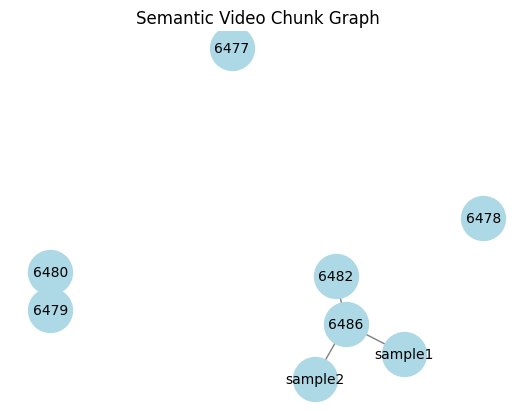

In [87]:
import matplotlib.pyplot as plt
import networkx as nx

# Set layout
pos = nx.spring_layout(G, seed=42)  # you can try other layouts like shell_layout or kamada_kawai_layout

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray')

# Draw labels (chunk_id as labels)
labels = {node: G.nodes[node]['video_id'] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10)

# Show the graph
plt.title("Semantic Video Chunk Graph")
plt.axis('off')
plt.show()
